# Preliminary operations

In [ ]:
!pip install contractions
!pip install transformers
!pip install sentencepiece
!pip install sentence-transformers
!pip install emoji

In [ ]:
# Utility
from google.colab import drive
import pandas as pd
pd.set_option('display.max_rows', 500)
from shutil import copyfile
from collections import Counter
import copy
import csv
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import itertools
import numpy as np
import time

# String operations
import re
import string
import ast
import contractions
from emoji import demojize

# Nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.models import Doc2Vec
from sklearn import metrics

# Summarization
from transformers import BartForConditionalGeneration, BartTokenizer
import sentencepiece
from sentence_transformers import SentenceTransformer

In [ ]:
drive.mount('/content/gdrive')

# Clustering

We implement clustering through 3 different approaches: TF-IDF, Doc2Vec and BERTweet. We use K-Means and hierarchical algorithms.

## TF-IDF

First of all, we apply some pre-processing techniques.

In [ ]:
df = pd.read_csv('gdrive/My Drive/Text Mining & Search/preprocessed.csv')
df.head()

,Datetime,Text,Username,Likes,Retweets,Hashtags,Mentions
0,2022-12-18 23:57:22+00:00,"despite conceding 3️⃣ goals apiece, &amp; hugo...",JioCinema,58,15,"['FIFAWorldCup', 'ARGFRA', 'Qatar2022', 'FIFAW...","['emimartinezz1', 'Mahindra_Auto']"
1,2022-12-18 23:54:59+00:00,"12/18/2022 - 📍times square, nyc argentina beat...",galassitweets,13,2,"['FIFAWorldCup', 'ArgentinaVsFrance', 'Qatar20...",[]
2,2022-12-18 23:54:52+00:00,"and at 2:52am on monday, december 19, it's a w...",gabetan13,28,0,"['FIFAWorldCup', 'Qatar2022']",[]
3,2022-12-18 23:54:48+00:00,would the question be even asked if it was ano...,farjad99,16,3,['WorldcupQatar2022'],['IlmFeed']
4,2022-12-18 23:53:22+00:00,"""it is a dress for an official occasion, worn ...",ShamoonHafez,920,113,"['Qatar2022', 'FifaWorldCup']",[]


In [ ]:
# Demojizing
df['Lemmas'] = df['Text'].apply(lambda x: demojize(x, delimiters = (' _', '_ ')).lower())
print(df['Lemmas'].head())

0    despite conceding  _keycap_3_  goals apiece, &...
1    12/18/2022 -  _round_pushpin_ times square, ny...
2    and at 2:52am on monday, december 19, it's a w...
3    would the question be even asked if it was ano...
4    "it is a dress for an official occasion, worn ...
Name: Lemmas, dtype: object


In [ ]:
# Removing numbers
df['Lemmas'] = df['Lemmas'].apply(lambda x: re.sub(r'\d+', '', x))

We turn emojis into text, still making them recognizable by enclosing them within '_'. They will be useful for our tasks.

In [ ]:
# Fixing contractions, e.g. you're -> you are
df['Lemmas'] = df['Lemmas'].apply(lambda x: contractions.fix(x))
print(df['Lemmas'].head())

0    despite conceding  _keycap__  goals apiece, &a...
1    // -  _round_pushpin_ times square, nyc argent...
2       and at :am on monday, december , it is a wrap!
3    would the question be even asked if it was ano...
4    "it is a dress for an official occasion, worn ...
Name: Lemmas, dtype: object


We remove the punctuations and other symbols.

In [ ]:
custom = list(string.punctuation)
custom.extend(['€', '‘', '–', '’', '|', '\\', '⏱', '↯', ' ⃣0⃣ ', ' ⃣', '↓',
               '•', '“', '”', '…', "'⃣", '◘'])
custom.remove("'")
custom.remove('-')
# We keep the '_' symbol because it's the delimeter for the emojis
custom.remove('_')

def remove_punctuation(text, punct):
  punctuation_free = ''.join([i for i in text if i not in punct])
  return punctuation_free

def remove_custom(text):
  # We substitute the "'" and '-' with a white space
  custom = re.sub("(')|(-)", ' ', text)
  return custom

df['Lemmas'] = df['Lemmas'].apply(lambda x: remove_punctuation(x, custom))
df['Lemmas'] = df['Lemmas'].apply(lambda x: remove_custom(x))
print(df['Lemmas'].head())

0    despite conceding  _keycap__  goals apiece amp...
1        _round_pushpin_ times square nyc argentina...
2           and at am on monday december  it is a wrap
3    would the question be even asked if it was ano...
4    it is a dress for an official occasion worn fo...
Name: Lemmas, dtype: object


The processes above may have created some extra-space. Let's check and remove them.

In [ ]:
def remove_extra_spaces(text):
  new_text = ' '.join(text.split()) 
  return new_text

df['Lemmas'] = df['Lemmas'].apply(lambda x: remove_extra_spaces(x))

spaces = 0
newlines = 0
tabs = 0
length = 0

for i in range(0, len(df)):
  spaces+=len(re.findall(r'\s\s+', df['Lemmas'][i]))
  newlines+=len(re.findall(r'\n\n+', df['Lemmas'][i]))
  tabs+=len(re.findall(r'\t+', df['Lemmas'][i]))
  length+=len(df['Lemmas'][i])

print("Number of multiple spaces:", spaces)
print("Number of multiple newlines:", newlines)
print("Number of multiple tabs:", tabs)
print('Overall tweets length:', length)

Number of multiple spaces: 0
Number of multiple newlines: 0
Number of multiple tabs: 0
Overall tweets length: 13440375


Before applying tf-idf, we tokenize and lemmatize the texts.

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def tokenize_tweets(text):
  return tokenizer.tokenize(text)

def lemmatize_tweets(text):
  return [(lemmatizer.lemmatize(w)) for w in tokenize_tweets((text))]

Due to several grammatical errors detected in the tweets, we remove single letters (except v which stands for vs). In addition, we remove the most frequently used emoji that would otherwise overly affect clustering.

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'q', 'r', 'u', 's',
                  'w', 'z', 'amp', 'ha', 'le', 'u', 'wa', 'doe', '_', '_keycap_', '__', '_fire_',
                  '&amp', '_keycap__', 'keycap', 'im', 'ah', 'wa', '&', '_soccer_ball_'])

We normalize the tweets by specifying *norm = 'l2'* and we take uni-grams, bi-grams and 3-grams. Moreover, we specify a minimum (10) and a maximum frequency (80%) for the words, also in order to reduce the computational cost. The tokenization and the lemmatization are computed inside the function through the *lemmatize_tweets* call.

In [ ]:
st = time.time()

tfidf_vectorizer = TfidfVectorizer(tokenizer = lemmatize_tweets, min_df = 10,
                                   max_df = 0.8, norm = 'l2', ngram_range = (1, 3),
                                   stop_words = stopwords)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['Lemmas'])

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  27.95131492614746 seconds


In [ ]:
tfidf_matrix.shape

(89261, 23750)

We obtained a matrix with 89261 rows and 23750 features.

In [ ]:
X = tfidf_matrix

### K-Means

We apply the elbow method in order to find the optimal number of clusters.

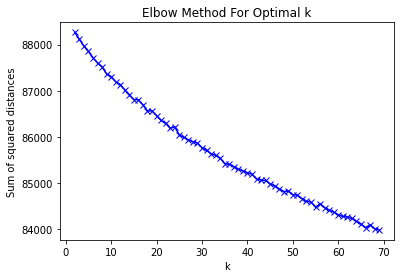

In [ ]:
Sum_of_squared_distances = []
K = range(2, 70)
for k in K:
  km = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
  km = km.fit(X)
  Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems that optimal clustering cannot be achieved with this representation (TF-IDF). However, let's try with 40 clusters, maybe we'll find some useful insights in some of them.

In [ ]:
st = time.time()

true_k = 40
km = KMeans(n_clusters = true_k, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 0)
km.fit(X)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

labels = km.labels_
result = {'cluster': labels, 'documents': df["Text"]}
result = pd.DataFrame(result)

Execution time:  75.23997902870178 seconds


In [ ]:
silhouette = metrics.silhouette_score(X, labels)
silhouette

0.009260033109831336

In [ ]:
silhouette = metrics.silhouette_score(X, labels, metric = 'cosine')
silhouette

0.017574043902008212

Both the silhouette coefficients are very low, as we expected.

In [ ]:
clusters = [0] * 40
for i in range(len(clusters)):
  clusters[i] = result[result.cluster == i]['documents']
  clusters[i].reset_index(drop = True, inplace = True)

We may obtain a summary from each cluster through BART model.

In [ ]:
model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn', model_max_length = 1024)

In [ ]:
for i in range(len(clusters)):
  text = '. '.join(''.join(l) for l in clusters[i]).strip()
  text = text.replace("..", ".")

  tokens_input = tokenizer_bart.encode(text, return_tensors = "pt", max_length = 1024, truncation = True)
  summary_ids = model_bart.generate(tokens_input, max_new_tokens = 180)

  summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens = True)
  print('Summary for cluster ' + str(i) + ':' + '\n' + summary)

Summary for cluster 0:
A 14-year-old girl in tehran was identified by cameras after removing her hijab and died in the hospital after being arrested by government forces due to a severe rupture of her vagina. 41 years ago, iranian women were active participants in the islamic revolution of iran. 43 years of forced religion has made iranians allergic to the concept of islam.
Summary for cluster 1:
Lionel messi wins the 2022 world cup golden ball for the player of the tournament. mbappe wins the golden boot. coye walters hastings as runner up. congratulations to for winning the final, and to for showing such spirit and fight to the end.
Summary for cluster 2:
Morocco join cameroon, senegal and ghana to achieve the great feat as an african nation. morocco beat senegal 3-0 sunday in a round of 16 match to set up a quarterfinal clash with england. "i am not here to be a politician. we want to fly africa's flag high just like senegal, ghana, and cameroon"
Summary for cluster 3:
Messi fans ta

Despite the low clustering performances, probably due to the use of tf-idf (unable to capture context), we notice the presence of several interesting clusters that highlight different aspects of this World Cup.

### Hierarchical

Due to limited computational resources, we cannot perform hierarchical clustering among all the tweets. So, we choose a subset containing the 20000 most liked tweets.

In [ ]:
most_likes = df.sort_values(by = ['Likes'], ascending = False)

In [ ]:
st = time.time()

tfidf_vectorizer = TfidfVectorizer(tokenizer = lemmatize_tweets, min_df = 10,
                                   max_df = 0.8, norm = 'l2', ngram_range = (1, 3),
                                   stop_words = stopwords)

tfidf_matrix = tfidf_vectorizer.fit_transform(most_likes['Lemmas'][:20000])

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  6.836190700531006 seconds


In [ ]:
tfidf_matrix.shape

(20000, 6090)

In [ ]:
X = tfidf_matrix

In order to compute the linkage matrix, we have to compute the distance based on the cosine similarity.

In [ ]:
st = time.time()

dist = 1 - metrics.pairwise.cosine_similarity(X.toarray())

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  70.7751407623291 seconds


We perform Ward's linkage. This method specifies the distance between two clusters as the increase in the "error sum of squares" (ESS) after fusing two clusters into a single cluster.

In [ ]:
st = time.time()

linkage_matrix = ward(dist)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  2746.343876361847 seconds


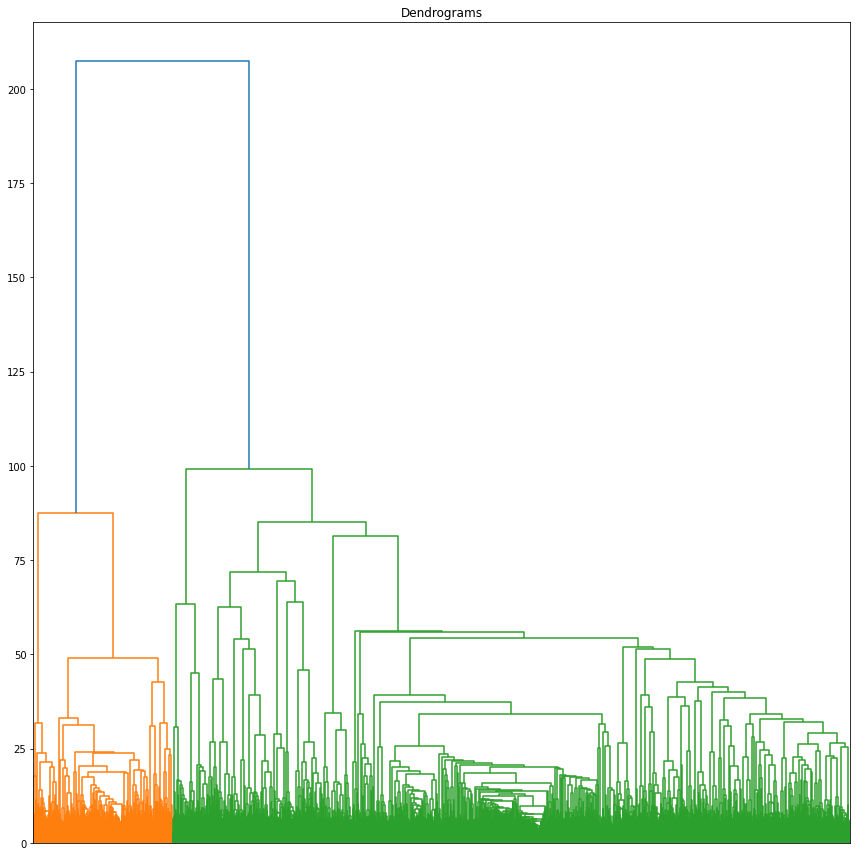

In [ ]:
plt.figure(figsize = (12, 12))
plt.title("Dendrograms")
dendrogram = dendrogram(linkage_matrix)
plt.xticks([])
plt.tight_layout()

A good point to cut the dendrogram may be 11 clusters. Let's see if we find some insights.

In [ ]:
labels = fcluster(linkage_matrix, 11, criterion = 'maxclust')

In [ ]:
silhouette = metrics.silhouette_score(X, labels)
silhouette

0.0038785589679949444

In [ ]:
silhouette = metrics.silhouette_score(X, labels, metric = 'cosine')
silhouette

0.007049168921535969

Silhouette scores very low.

In [ ]:
result = {'cluster': labels, 'documents': most_likes["Text"][:20000]}
result = pd.DataFrame(result)

In [ ]:
clusters = [0] * 11
for i in range(len(clusters)):
  clusters[i] = result[result.cluster == i]['documents']
  clusters[i].reset_index(drop = True, inplace = True)

We may obtain a summary from each cluster through BART model.

In [ ]:
model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn', model_max_length = 1024)

In [ ]:
for i in range(len(clusters)):
  text = '. '.join(''.join(l) for l in clusters[i]).strip()
  text = text.replace("..", ".")

  tokens_input = tokenizer_bart.encode(text, return_tensors = "pt", max_length = 1024, truncation = True)
  summary_ids = model_bart.generate(tokens_input, max_new_tokens = 180)

  summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens = True)
  print('Summary for cluster ' + str(i) + ':' + '\n' + summary)

Summary for cluster 0:
CNN.com will feature iReporter photos in a weekly Travel Snapshots gallery. Please submit your best shots of the U.S. for next week. Visit CNN.com/Travel next Friday for a new gallery of snapshots from around the world. Please share your best photos of the world with CNN iReport.
Summary for cluster 1:
Jung kook (bts) feat. fahad al kubaisi. is from the fifa world cup qatar 2022™️ official soundtrack. Show your football skills at pop up in sandton city centre in on 22nd and 23rd october, for a chance to win exclusive fifaWorld Cup packages.
Summary for cluster 2:
Lionel messi: "no, i'm not gonna retire from the national team. i want to keep playing as world cup champions with argentina shirt" karim benzema will miss the world cup. sadio mané will not be able to be part of the squad as he's not recovering from his injury. christopher nkunku will miss world cup due to injury in today's training session.
Summary for cluster 3:
Ghana have qualified for the fifa world

Although the summaries of several clusters seem to make no sense, there are some very interesting ones.

## Doc2Vec

https://radimrehurek.com/gensim/models/doc2vec.html

First of all, we apply some pre-processing techniques.

In [ ]:
df = pd.read_csv('gdrive/My Drive/Text Mining & Search/preprocessed.csv')
df.head()

,Datetime,Text,Username,Likes,Retweets,Hashtags,Mentions
0,2022-12-18 23:57:22+00:00,"despite conceding 3️⃣ goals apiece, &amp; hugo...",JioCinema,58,15,"['FIFAWorldCup', 'ARGFRA', 'Qatar2022', 'FIFAW...","['emimartinezz1', 'Mahindra_Auto']"
1,2022-12-18 23:54:59+00:00,"12/18/2022 - 📍times square, nyc argentina beat...",galassitweets,13,2,"['FIFAWorldCup', 'ArgentinaVsFrance', 'Qatar20...",[]
2,2022-12-18 23:54:52+00:00,"and at 2:52am on monday, december 19, it's a w...",gabetan13,28,0,"['FIFAWorldCup', 'Qatar2022']",[]
3,2022-12-18 23:54:48+00:00,would the question be even asked if it was ano...,farjad99,16,3,['WorldcupQatar2022'],['IlmFeed']
4,2022-12-18 23:53:22+00:00,"""it is a dress for an official occasion, worn ...",ShamoonHafez,920,113,"['Qatar2022', 'FifaWorldCup']",[]


In [ ]:
# Demojizing
df['Lemmas'] = df['Text'].apply(lambda x: demojize(x, delimiters = (' _', '_ ')).lower())
print(df['Lemmas'].head())

0    despite conceding  _keycap_3_  goals apiece, &...
1    12/18/2022 -  _round_pushpin_ times square, ny...
2    and at 2:52am on monday, december 19, it's a w...
3    would the question be even asked if it was ano...
4    "it is a dress for an official occasion, worn ...
Name: Lemmas, dtype: object


In [ ]:
# Removing numbers
df['Lemmas'] = df['Lemmas'].apply(lambda x: re.sub(r'\d+', '', x))

In [ ]:
# Fixing contractions, e.g. you're -> you are
df['Lemmas'] = df['Lemmas'].apply(lambda x: contractions.fix(x))
print(df['Lemmas'].head())

0    despite conceding  _keycap__  goals apiece, &a...
1    // -  _round_pushpin_ times square, nyc argent...
2       and at :am on monday, december , it is a wrap!
3    would the question be even asked if it was ano...
4    "it is a dress for an official occasion, worn ...
Name: Lemmas, dtype: object


We remove the punctuations and other symbols.

In [ ]:
custom = list(string.punctuation)
custom.extend(['€', '‘', '–', '’', '|', '\\', '⏱', '↯', ' ⃣0⃣ ', ' ⃣', '↓',
               '•', '“', '”', '…', "'⃣", '◘'])
custom.remove("'")
custom.remove('-')
# We keep the '_' symbol because it's the delimeter for the emojis
custom.remove('_')

def remove_punctuation(text, punct):
  punctuation_free = ''.join([i for i in text if i not in punct])
  return punctuation_free

def remove_custom(text):
  # We substitute the "'" and '-' with a white space
  custom = re.sub("(')|(-)", ' ', text)
  return custom

df['Lemmas'] = df['Lemmas'].apply(lambda x: remove_punctuation(x, custom))
df['Lemmas'] = df['Lemmas'].apply(lambda x: remove_custom(x))
print(df['Lemmas'].head())

0    despite conceding  _keycap__  goals apiece amp...
1        _round_pushpin_ times square nyc argentina...
2           and at am on monday december  it is a wrap
3    would the question be even asked if it was ano...
4    it is a dress for an official occasion worn fo...
Name: Lemmas, dtype: object


The processes above may have created some extra-space. Let's check and remove them.

In [ ]:
def remove_extra_spaces(text):
  new_text = ' '.join(text.split()) 
  return new_text

df['Lemmas'] = df['Lemmas'].apply(lambda x: remove_extra_spaces(x))

spaces = 0
newlines = 0
tabs = 0
length = 0

for i in range(0, len(df)):
  spaces+=len(re.findall(r'\s\s+', df['Lemmas'][i]))
  newlines+=len(re.findall(r'\n\n+', df['Lemmas'][i]))
  tabs+=len(re.findall(r'\t+', df['Lemmas'][i]))
  length+=len(df['Lemmas'][i])

print("Number of multiple spaces:", spaces)
print("Number of multiple newlines:", newlines)
print("Number of multiple tabs:", tabs)
print('Overall tweets length:', length)

Number of multiple spaces: 0
Number of multiple newlines: 0
Number of multiple tabs: 0
Overall tweets length: 13440375


Now we tokenize and lemmatize the texts, before applying Doc2Vec.

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def tokenize_tweets(text):
  return tokenizer.tokenize(text)

def lemmatize_tweets(text):
  return [(lemmatizer.lemmatize(w)) for w in tokenize_tweets((text))]

Due to several grammatical errors detected in the tweets, we remove single letters (except v which stands for vs). In addition, we remove the most frequently used emoji that would otherwise overly affect clustering.

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'q', 'r', 'u', 's',
                  'w', 'z', 'amp', 'ha', 'le', 'u', 'wa', 'doe', '_', '_keycap_', '__', '_fire_',
                  '&amp', '_keycap__', 'keycap', 'im', 'ah', 'wa', '&', '_soccer_ball_'])

In [ ]:
df['Lemmas'] = df['Lemmas'].apply(lambda x: lemmatize_tweets(x))
df['Lemmas'] = df['Lemmas'].apply(lambda x: [item for item in x if item not in stopwords])

We apply a tag for each document.

In [ ]:
LabeledSentences = gensim.models.doc2vec.TaggedDocument
all_content = []
j = 0
for el in df["Lemmas"]:
  all_content.append(LabeledSentences(el, [j]))
  j+=1
print("Number of texts processed: ", j)

Number of texts processed:  89261


Finding the best parameter combination for Doc2Vec.

In [ ]:
dm = [1, 0]
vector_size = [64, 128, 256]
hs = [1, 0]
params = [{'dm': item[0],
           'vector_size': item[1],
           'hs': item[2]
            } for item in
              list(itertools.product(*[dm,
                                       vector_size,
                                       hs]))
          ]

{'dm': 1, 'vector_size': 64, 'hs': 1}


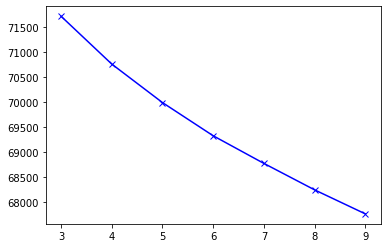

{'dm': 1, 'vector_size': 64, 'hs': 0}


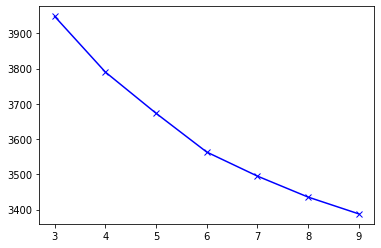

{'dm': 1, 'vector_size': 128, 'hs': 1}


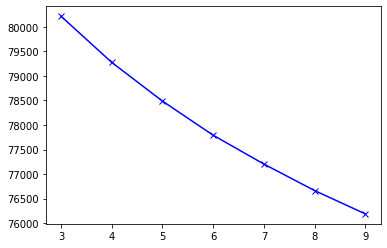

{'dm': 1, 'vector_size': 128, 'hs': 0}


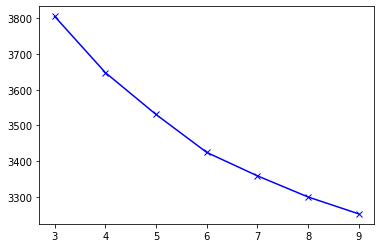

{'dm': 1, 'vector_size': 256, 'hs': 1}


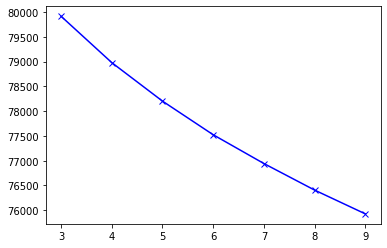

{'dm': 1, 'vector_size': 256, 'hs': 0}


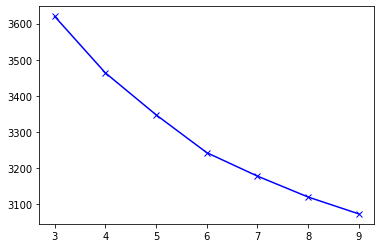

{'dm': 0, 'vector_size': 64, 'hs': 1}


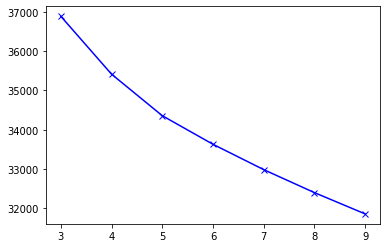

{'dm': 0, 'vector_size': 64, 'hs': 0}


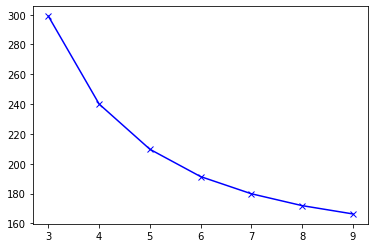

{'dm': 0, 'vector_size': 128, 'hs': 1}


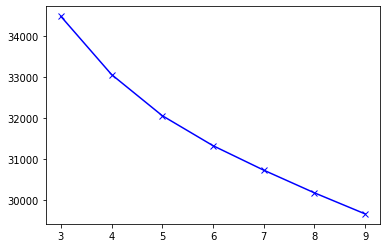

{'dm': 0, 'vector_size': 128, 'hs': 0}


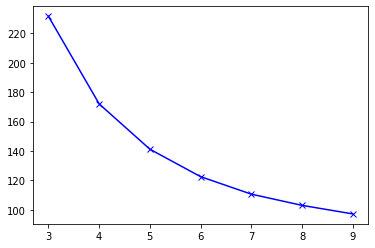

{'dm': 0, 'vector_size': 256, 'hs': 1}


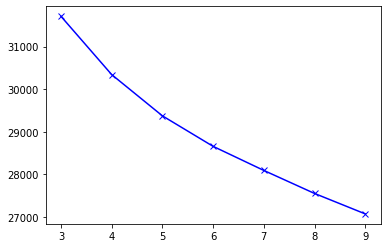

{'dm': 0, 'vector_size': 256, 'hs': 0}


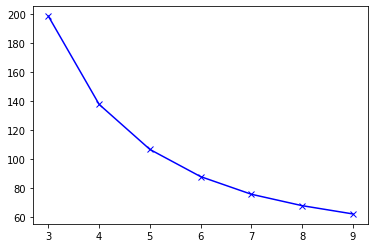

Execution time:  2627.947865009308 seconds


In [ ]:
st = time.time()

param_list = []
for param in params:
  try:
    model = Doc2Vec(all_content,
                    dm = param['dm'], 
                    vector_size = param['vector_size'], 
                    workers = 8,
                    window = 2,
                    hs = param['hs'])
  except Exception as error:
    print(f"Cannot evaluate model with parameters {param} because of error: {error}")
  Sum_of_squared_distances = []
  # Evaluating through kmeans and elbow method
  K = range(3, 10)
  for k in K:
    km = KMeans(n_clusters = k, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 0)
    X = model.docvecs.vectors_docs
    km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
  param_list.append(params)
  plt.figure()
  plt.plot(K, Sum_of_squared_distances, 'bx-')
  print(param)
  plt.show()

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

The best combination is:
* dm = 0.
* vector_size = 256.
* hs = 0.

In [ ]:
st = time.time()

model = Doc2Vec(all_content,
                dm = 0, 
                vector_size = 256, 
                workers = 8,
                window = 2,
                seed = 0,
                hs = 0)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  57.846723556518555 seconds


### K-Means

Now let's print the elbow curve with the parameters above.

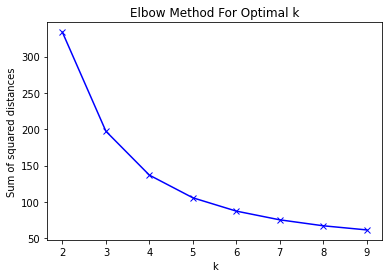

In [ ]:
Sum_of_squared_distances = []
K = range(2, 10)
for k in K:
  km = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
  X = model.docvecs.vectors_docs
  km.fit(X)
  Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The optimal number of clusters k is 4.

In [ ]:
st = time.time()

true_k = 4
km = KMeans(n_clusters = true_k, init = 'k-means++', random_state = 0)
X = model.docvecs.vectors_docs
km.fit(X)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

labels = km.labels_
result = {'cluster': labels, 'documents': df["Text"]}
result = pd.DataFrame(result)

Execution time:  15.099733114242554 seconds


In [ ]:
silhouette = metrics.silhouette_score(X, labels)
silhouette

0.40970913

In [ ]:
silhouette = metrics.silhouette_score(X, labels, metric = 'cosine')
silhouette

-0.084078535

The silhouette score based on the euclidean distance is much higher than before with the tf-idf representation. However, the silhouette computed through cosine similarity is very low (even lower than 0), probably because of the k-means algorithm.

In [ ]:
clusters = [0] * 4
for i in range(len(clusters)):
  clusters[i] = result[result.cluster == i]['documents']
  clusters[i].reset_index(drop = True, inplace = True)

We may obtain a summary from each cluster through BART model.

In [ ]:
model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn', model_max_length = 1024)

In [ ]:
for i in range(len(clusters)):
  text = '. '.join(''.join(l) for l in clusters[i]).strip()
  text = text.replace("..", ".")

  tokens_input = tokenizer_bart.encode(text, return_tensors = "pt", max_length = 1024, truncation = True)
  summary_ids = model_bart.generate(tokens_input, max_new_tokens = 180)

  summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens = True)
  print('Summary for cluster ' + str(i) + ':' + '\n' + summary)

Summary for cluster 0:
qatar hosted one of the greatest world cup's ever! safe, entertaining, welcoming and showcasing islam and arab culture superbly. western media are angry about the garment the emir put on messi. it's the same garment worn by kings and princes in the gulf nations. they are still envious of the success of thelionel messi of argentina dressed in bisht, a traditional arabic robe.
Summary for cluster 1:
lionel messi will not retire immediately from international football after finally capping an extraordinary career with argentina's first world cup since 1986. The amir hopes world cup success would motivate more giving for homeland. no asian country won. india: prepare. win.
Summary for cluster 2:
12/18/2022 - 📍times square, nyc argentina beats france on penalty kicks, winning world cup for third time. At 2:52am on monday, december 19, it's a wrap!see you in in 2026.
Summary for cluster 3:
qatar has made football worldwide! now even the americans are following it! this

We obtained 4 reasonable clusters (although we notice some errors).

### Hierarchical

We choose a subset as we did above.

In [ ]:
most_likes = df.sort_values(by = ['Likes'], ascending = False)

In [ ]:
LabeledSentences = gensim.models.doc2vec.TaggedDocument
all_content = []
j = 0
for el in most_likes['Lemmas'][:20000].values:
    all_content.append(LabeledSentences(el, [j]))
    j+=1
print("Number of texts processed: ", j)

Number of texts processed:  20000


In [ ]:
st = time.time()

model = Doc2Vec(all_content,
                dm = 0, 
                vector_size = 256, 
                window = 2,     
                workers = 8,
                min_count = 10,
                seed = 0,
                hs = 0)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  10.849609375 seconds


In [ ]:
X = model.docvecs.vectors_docs

In [ ]:
X.shape

(20000, 256)

In [ ]:
st = time.time()

dist = 1 - metrics.pairwise.cosine_similarity(X)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  3.838919162750244 seconds


In [ ]:
st = time.time()

linkage_matrix = ward(dist)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  2781.1482684612274 seconds


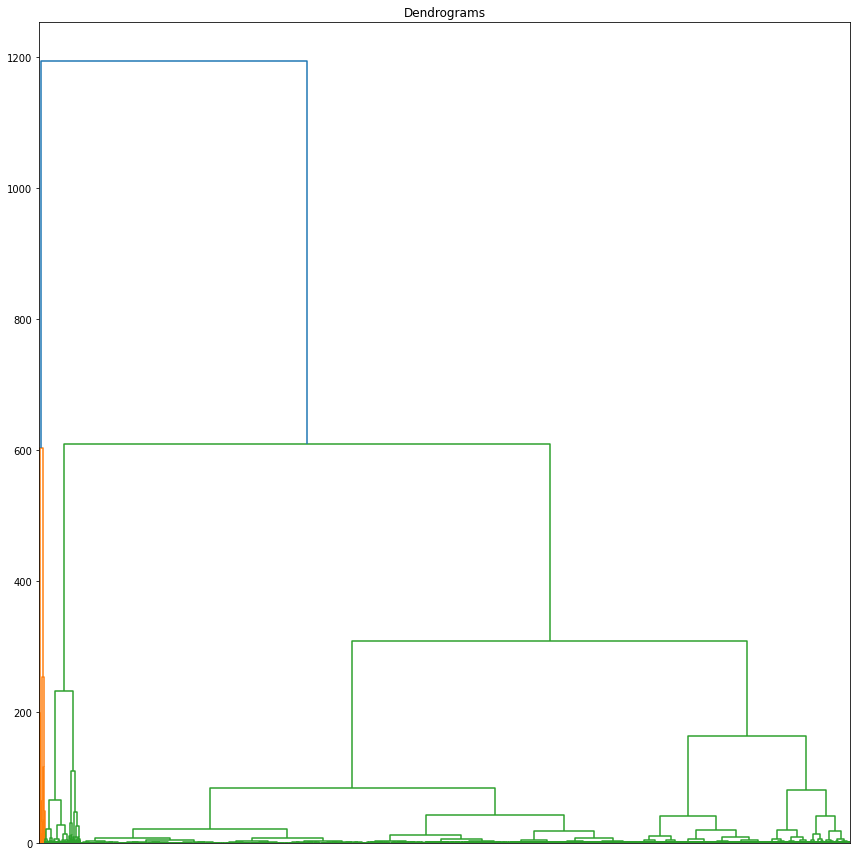

In [ ]:
plt.figure(figsize = (12, 12))
plt.title("Dendrograms")
dendrogram = dendrogram(linkage_matrix)
plt.xticks([])
plt.tight_layout()

*A* good point to cut the dendrogram may be 6 clusters. Let's see if we find some insights.

In [ ]:
labels = fcluster(linkage_matrix, 6, criterion = 'maxclust')

In [ ]:
silhouette = metrics.silhouette_score(X, labels)
silhouette

0.20193247

In [ ]:
silhouette_cos = metrics.silhouette_score(X, labels, metric = 'cosine')
silhouette_cos

0.311494

With this method both silhouette scores are higher than tf-idf. In particular, the score based on the cosine similarity is much better than the k-means algorithm, although the standard score (i.e. the euclidean one) is worse.

In [ ]:
result = {'cluster': labels, 'documents': most_likes["Text"][:20000]}
result = pd.DataFrame(result)

In [ ]:
clusters = [0] * 6
for i in range(len(clusters)):
  clusters[i] = result[result.cluster == i]['documents']
  clusters[i].reset_index(drop = True, inplace = True)

We may obtain a summary through BART model.

In [ ]:
model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn', model_max_length = 1024)

In [ ]:
for i in range(len(clusters)):
  text = '. '.join(''.join(l) for l in clusters[i]).strip()
  text = text.replace("..", ".")
  tokens_input = tokenizer_bart.encode(text, return_tensors = "pt", max_length = 1024, truncation = True)
  summary_ids = model_bart.generate(tokens_input, max_new_tokens = 180)

  summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens = True)
  print('Summary for cluster ' + str(i) + ':' + '\n' + summary)

Summary for cluster 0:
CNN.com will feature iReporter photos in a weekly Travel Snapshots gallery. Please submit your best shots of the U.S. for next week. Visit CNN.com/Travel next Friday for a new gallery of snapshots from around the world. Please share your best photos of the world with CNN iReport.
Summary for cluster 1:
Argentina beat France 1-0 in the world cup final. Lionel Messi scored the only goal of the game. Germany were thrown out of the tournament. Qatar will host the 2022 world cup. The tournament will be held in the city of Lusaka, Qatar, in 2022.
Summary for cluster 2:
Lionel messi and argentina are in the fifa world cup final with a convincing 3-0 win over croatia. morocco are really cooking in this world cup. i have a weird feeling my team england will win the. arjentina win after 36 years. i'm crowning this the most beautiful moment of the world cup so far.
Summary for cluster 3:
World Cup is halfway over. Who will score first at the 2022 world cup? Who will go to t

Some of these clusters seem to be meaningless.

## BERTweet

https://huggingface.co/r2d2/stsb-bertweet-base-v0

In [ ]:
df = pd.read_csv('gdrive/My Drive/Text Mining & Search/preprocessed.csv')
df.head()

,Datetime,Text,Username,Likes,Retweets,Hashtags,Mentions
0,2022-12-18 23:57:22+00:00,"despite conceding 3️⃣ goals apiece, &amp; hugo...",JioCinema,58,15,"['FIFAWorldCup', 'ARGFRA', 'Qatar2022', 'FIFAW...","['emimartinezz1', 'Mahindra_Auto']"
1,2022-12-18 23:54:59+00:00,"12/18/2022 - 📍times square, nyc argentina beat...",galassitweets,13,2,"['FIFAWorldCup', 'ArgentinaVsFrance', 'Qatar20...",[]
2,2022-12-18 23:54:52+00:00,"and at 2:52am on monday, december 19, it's a w...",gabetan13,28,0,"['FIFAWorldCup', 'Qatar2022']",[]
3,2022-12-18 23:54:48+00:00,would the question be even asked if it was ano...,farjad99,16,3,['WorldcupQatar2022'],['IlmFeed']
4,2022-12-18 23:53:22+00:00,"""it is a dress for an official occasion, worn ...",ShamoonHafez,920,113,"['Qatar2022', 'FifaWorldCup']",[]


In [ ]:
text = df['Text'].tolist()
for el in text:
  el = el.strip()

st = time.time()

model = SentenceTransformer('r2d2/stsb-bertweet-base-v0')
X = model.encode(text)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  14503.928996801376 seconds


In [ ]:
X.shape

(89261, 768)

### K-Means

Elbow curve.

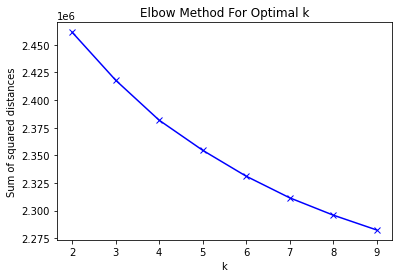

In [ ]:
Sum_of_squared_distances = []
K = range(2, 10)
for k in K:
  km = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
  km.fit(X)
  Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The optimal number of clusters k is 5.

In [ ]:
st = time.time()

true_k = 5
km = KMeans(n_clusters = true_k, init = 'k-means++', random_state = 0)
km.fit(X)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

labels = km.labels_
result = {'cluster': labels, 'documents': df["Text"]}
result = pd.DataFrame(result)

Execution time:  67.02619504928589 seconds


In [ ]:
silhouette = metrics.silhouette_score(X, labels)
silhouette

0.022877026

In [ ]:
silhouette = metrics.silhouette_score(X, labels, metric = 'cosine')
silhouette

0.03742937

Silhouette scores low again.

In [ ]:
clusters = [0] * 5
for i in range(len(clusters)):
  clusters[i] = result[result.cluster == i]['documents']
  clusters[i].reset_index(drop = True, inplace = True)

We may obtain a summary through BART model.

In [ ]:
model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn', model_max_length = 1024)

In [ ]:
for i in range(len(clusters)):
  text = '. '.join(''.join(l) for l in clusters[i]).strip()
  text = text.replace("..", ".")

  tokens_input = tokenizer_bart.encode(text, return_tensors = "pt", max_length = 1024, truncation = True)
  summary_ids = model_bart.generate(tokens_input, max_new_tokens = 180)

  summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens = True)
  print('Summary for cluster ' + str(i) + ':' + '\n' + summary)

Summary for cluster 0:
World Cup final was a grand success despite the haters and skeptics trying to make it appear otherwise. Western media are angry about the garment the emir put on messi. It's the same garment worn by kings and princes in the gulf nations. They are still envious of the success of the. when you look like a dictator and act like one, doors automatically open dispute not having a ticket.
Summary for cluster 1:
12/18/2022 - 📍times square, nyc argentina beats france on penalty kicks, winning world cup for third time. highlight of the day: white people crying over covering messi with arab traditional cloth (besht). what a music to my ears ❤️ cry louder boys!. lionel scaloni celebrated argentine's world cup win in the same shirt he wore when he won the u-20 world cup in 1997. if messi had worn a controversial one love rainbow armband, lineker and the rest would probs have praised him. since he wore an arabian bisht, coverage was negative.
Summary for cluster 2:
Argentina 

### Hierarchical

We choose a subset as we did above.

In [ ]:
most_likes = df.sort_values(by = ['Likes'], ascending = False)

In [ ]:
text = most_likes['Text'][:20000].tolist()
for el in text:
  el = el.strip()

st = time.time()

model = SentenceTransformer('r2d2/stsb-bertweet-base-v0')
X = model.encode(text)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  3023.805335998535 seconds


In [ ]:
X.shape

(20000, 768)

In [ ]:
st = time.time()

dist = 1 - metrics.pairwise.cosine_similarity(X)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  6.679314613342285 seconds


In [ ]:
st = time.time()

linkage_matrix = ward(dist)

et = time.time()
print('Execution time: ', str(et - st), 'seconds')

Execution time:  3364.1566858291626 seconds


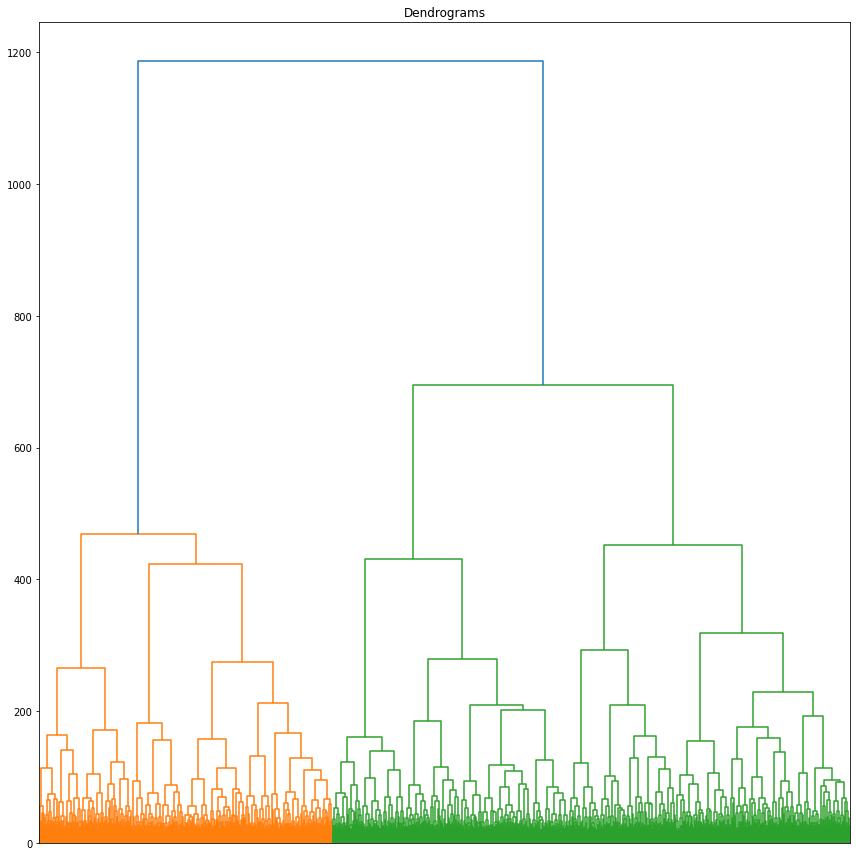

In [ ]:
plt.figure(figsize = (12, 12))
plt.title("Dendrograms")
dendrogram = dendrogram(linkage_matrix)
plt.xticks([])
plt.tight_layout()

We may cut the dendrogram at 12 clusters.

In [ ]:
labels = fcluster(linkage_matrix, 12, criterion = 'maxclust')

In [ ]:
silhouette = metrics.silhouette_score(X, labels)
silhouette

-0.0116727445

In [ ]:
silhouette_cos = metrics.silhouette_score(X, labels, metric = 'cosine')
silhouette_cos

-0.020619929

**Both** silhouette scores are negative. This is not a good clustering.

In [ ]:
result = {'cluster': labels, 'documents': most_likes["Text"][:20000]}
result = pd.DataFrame(result)

In [ ]:
clusters = [0] * 12
for i in range(len(clusters)):
  clusters[i] = result[result.cluster == i]['documents']
  clusters[i].reset_index(drop = True, inplace = True)

We may obtain a summary through BART model.

In [ ]:
model_bart = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer_bart = BartTokenizer.from_pretrained('facebook/bart-large-cnn', model_max_length = 1024)

In [ ]:
for i in range(len(clusters)):
  text = '. '.join(''.join(l) for l in clusters[i]).strip()
  text = text.replace("..", ".")

  tokens_input = tokenizer_bart.encode(text, return_tensors = "pt", max_length = 1024, truncation = True)
  summary_ids = model_bart.generate(tokens_input, max_new_tokens = 180)

  summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens = True)
  print('Summary for cluster ' + str(i) + ':' + '\n' + summary)

Summary for cluster 0:
CNN.com will feature iReporter photos in a weekly Travel Snapshots gallery. Please submit your best shots of the U.S. for next week. Visit CNN.com/Travel next Friday for a new gallery of snapshots from around the world. Please share your best photos of the world with CNN iReport.
Summary for cluster 1:
christopher nkunku will miss the world cup due to injury in today's training session. alex scott sports the armband after england's decision to abandon the gesture over fifa sanctions. andré onana has been removed from cameroon's squad. cristiano ronaldo on links of al nassr deal done: "no, that's not true — not true"
Summary for cluster 2:
Portugal coach fernando santos on his future: "tomorrow i will fly to lisbon and we will discuss with the president about my future, as always". The pitch invader during the portugal-uruguay match, italian guy mario ferri, has just announced that he has been released with no consequences. sadio mané will miss the world cup, sene